<a href="https://colab.research.google.com/github/DreamingNight/BookxNoteData/blob/master/chapter03/Chapter%203%20-%20Looking%20Inside%20LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Chapter 3 - Looking Inside Transformer LLMs</h1>
<i>An extensive look into the transformer architecture of generative LLMs</i>

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961"><img src="https://img.shields.io/badge/Buy%20the%20Book!-grey?logo=amazon"></a>
<a href="https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/"><img src="https://img.shields.io/badge/O'Reilly-white.svg?logo=data:image/svg%2bxml;base64,PHN2ZyB3aWR0aD0iMzQiIGhlaWdodD0iMjciIHZpZXdCb3g9IjAgMCAzNCAyNyIgZmlsbD0ibm9uZSIgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIj4KPGNpcmNsZSBjeD0iMTMiIGN5PSIxNCIgcj0iMTEiIHN0cm9rZT0iI0Q0MDEwMSIgc3Ryb2tlLXdpZHRoPSI0Ii8+CjxjaXJjbGUgY3g9IjMwLjUiIGN5PSIzLjUiIHI9IjMuNSIgZmlsbD0iI0Q0MDEwMSIvPgo8L3N2Zz4K"></a>
<a href="https://github.com/HandsOnLLM/Hands-On-Large-Language-Models"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>


This notebook is for Chapter 3 of the [Hands-On Large Language Models](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961) book by [Jay Alammar](https://www.linkedin.com/in/jalammar) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/).

---

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961">
<img src="https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/images/book_cover.png" width="350"/></a>

### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---


In [ ]:
%%capture
!pip install transformers==4.46.2 accelerate>=0.31.0

In [ ]:
!pip list | grep transformers

sentence-transformers              3.4.1
transformers                       4.46.2


## 这本书主要是提供关于LLM的一些直觉intuition


# Loading the LLM

In [ ]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
import gc
gc.collect()

0

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

# Create a pipeline
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=200,
    do_sample=False,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

# The Inputs and Outputs of a Trained Transformer LLM


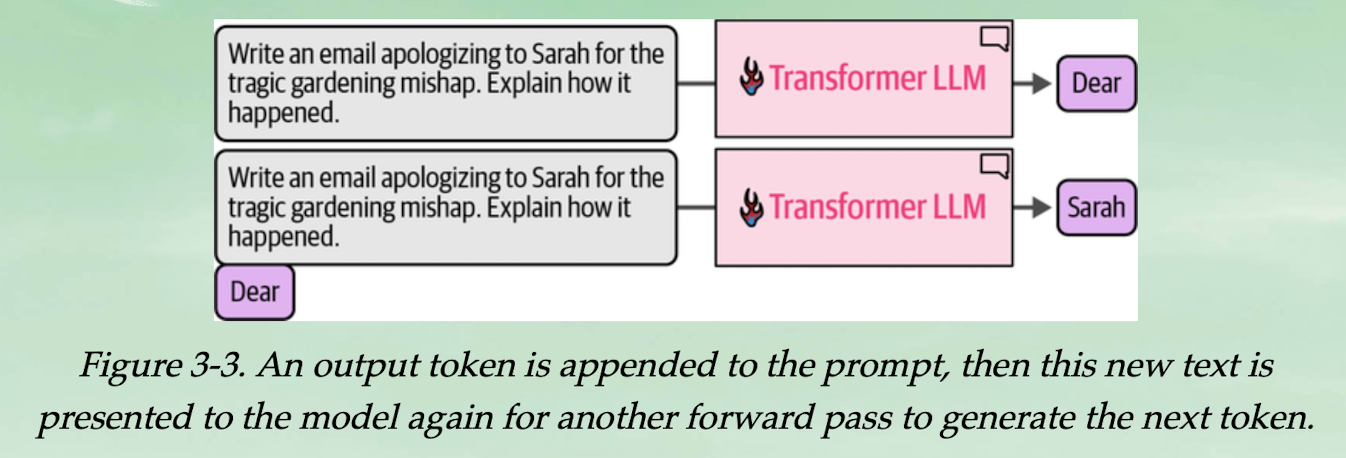

LLM 每次运行只能生成一个token，而不是直接输出所有的文本。并且在输入一个token后，他会和前面的内容组合起来作为input用于产生下一个token。用机器学习中的术语来描述，它是一个autoregressive models，自回归模型。
因为它会使用模型生成的token来生成下一个token。

所以文本生成模型经常被称为自回归模型。而BERT这种文本标识模型就不是自回归的。


---


但是，看到这我有一个疑问：LLM如何决定停止输出呢？总不能每次都到达context的上限，难道是它认为生成完毕的时候会输出作为结尾的那个特殊token吗？

In [ ]:
prompt = "Write an email apologizing to Sarah for the tragic gardening mishap. Explain how it happened."

output = generator(prompt)

print(output[0]['generated_text'])

 Mention the steps you're taking to prevent it in the future.

Dear Sarah,

I hope this message finds you well. I am writing to express my deepest apologies for the unfortunate incident that occurred in your garden. It was a tragic mishap that I never intended, and I am truly sorry for any distress it may have caused you.

The incident happened when I was attempting to help you with your gardening project. I had been researching various techniques to improve the health and growth of your plants, and I thought I had found the perfect solution. However, in my eagerness to implement this new method, I accidentally damaged some of your delicate flowers and disrupted the balance of your carefully cultivated ecosystem.

I understand that my actions have caused significant harm to your garden, and I am sincerely sorry for the consequences. Please know that I take full responsibility for my


In [ ]:
print(model)

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=3206

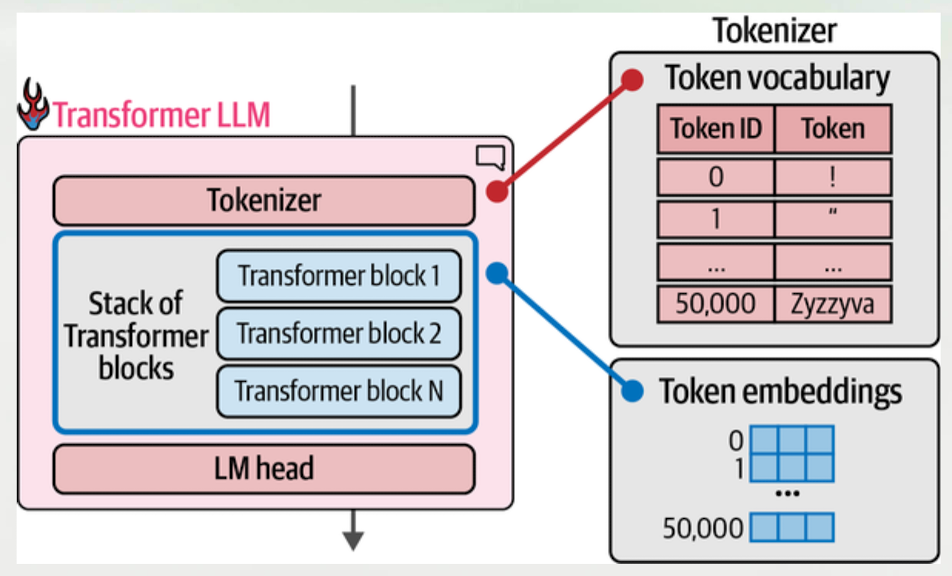

核心的组成成分就是:tokenzier（将输入转换为tokenIDs），然后是一系列transformer blocks，最后是LM head（将transfomer stack的输出转换为下一个token可能性的probability scores）。


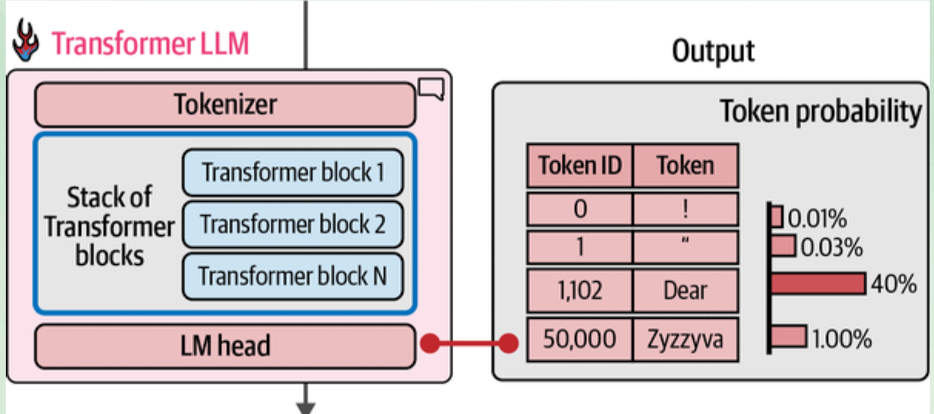

LM head是一个简单的神经网络层。而且它是transformer blocks后面可以接的多个heads中的一种。也有其他类型的transformer heads，比如用于序列分类的和用于token分类的。

# Choosing a single token from the probability distribution (sampling / decoding)

从LM head输出的probability scores里选取一个token的方法就是所谓的decoding strategy解码策略。
最简单最直观的方式就是选取可能性最大的那个token，被称为greedy decoding。但实践表明，这种方式在大部分情况下并不能给模型带来最好的效果。
一种更好的方式是增加一点点随机性，一种直观的方式就是根据probability scores本身作为被选取的概率进行采样，这样每个token都有可能被选择。
而控制分数高的token被选择的概率的参数就是temperature，所以temperature设置得高模型的输出随机性更强创造性更强。而greedy decoding就是把temperature设置为0的情况。


In [ ]:
prompt = "The capital of France is"

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

# Tokenize the input prompt
input_ids = input_ids.to("cuda")

# Get the output of the model before the lm_head
model_output = model.model(input_ids)

# Get the output of the lm_head
lm_head_output = model.lm_head(model_output[0])

In [10]:
#We can access the token probability scores for the last generated token using lm_head_output[0,-1],
# which uses the index 0 across the batch dimension; the index –1 gets us the last token in the sequence.
# This is now a list of probability scores for all 32,064 tokens
token_id = lm_head_output[0,-1].argmax(-1)
tokenizer.decode(token_id)

'Paris'

In [11]:
model_output[0].shape

torch.Size([1, 5, 3072])

In [12]:
lm_head_output.shape

torch.Size([1, 5, 32064])

# Speeding up generation by caching keys and values


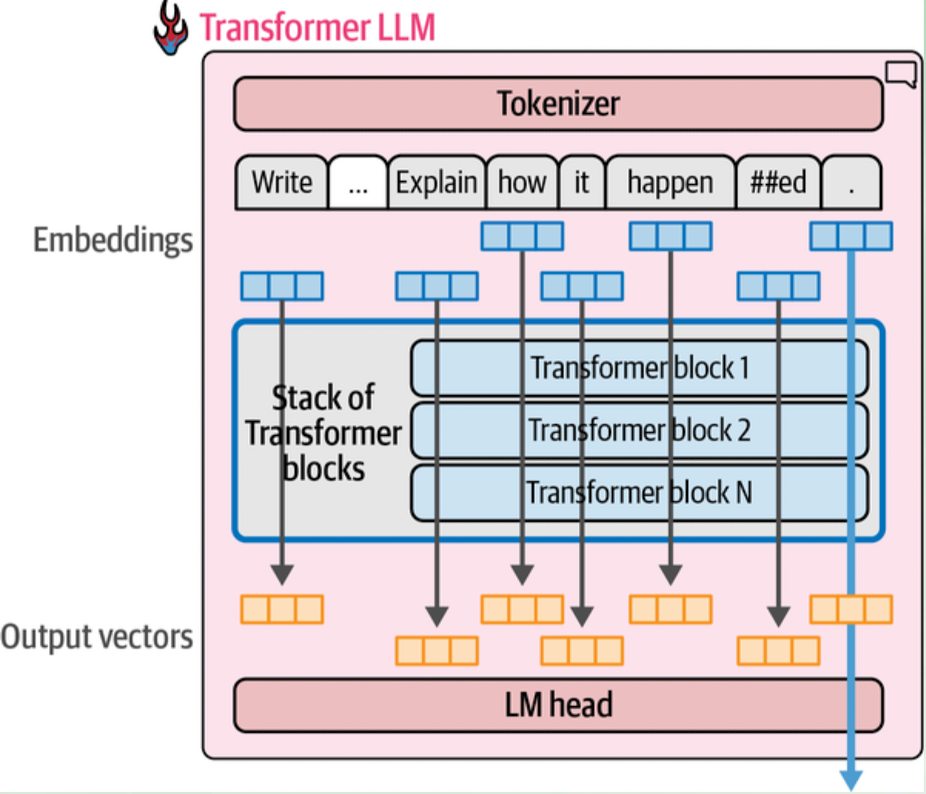

一种第一直觉的理解是：输入被tokenizer切分为tokens，而每一个token都流经自己的计算路径。如上图所示。
transformer模型对于每个能处理的token数量有一个限制，这就是模型的context length。
在每个token的stream中，从input vector开始，最终输出的是另一个vector作为结果，
对于文本生成模型，只有最后一个stream的输出结果vector用于预测下一个token（图中蓝色箭头）这个stream的output是LM head的唯一输入。
这样看起来好像前面的token stream没必要进行计算了，其实前面stream的计算过程是必须的，它们被用于计算最终的stream。在transformer blocks中会使用它们的早期输出。

因为每次都是增加上次产生的token到末尾作为输入重新计算，那么可以使用keys and values cache来缓存之前stream的计算结果来加速生成过程。下图展示了实际生成过程中，只有一个processing stream是激活的。

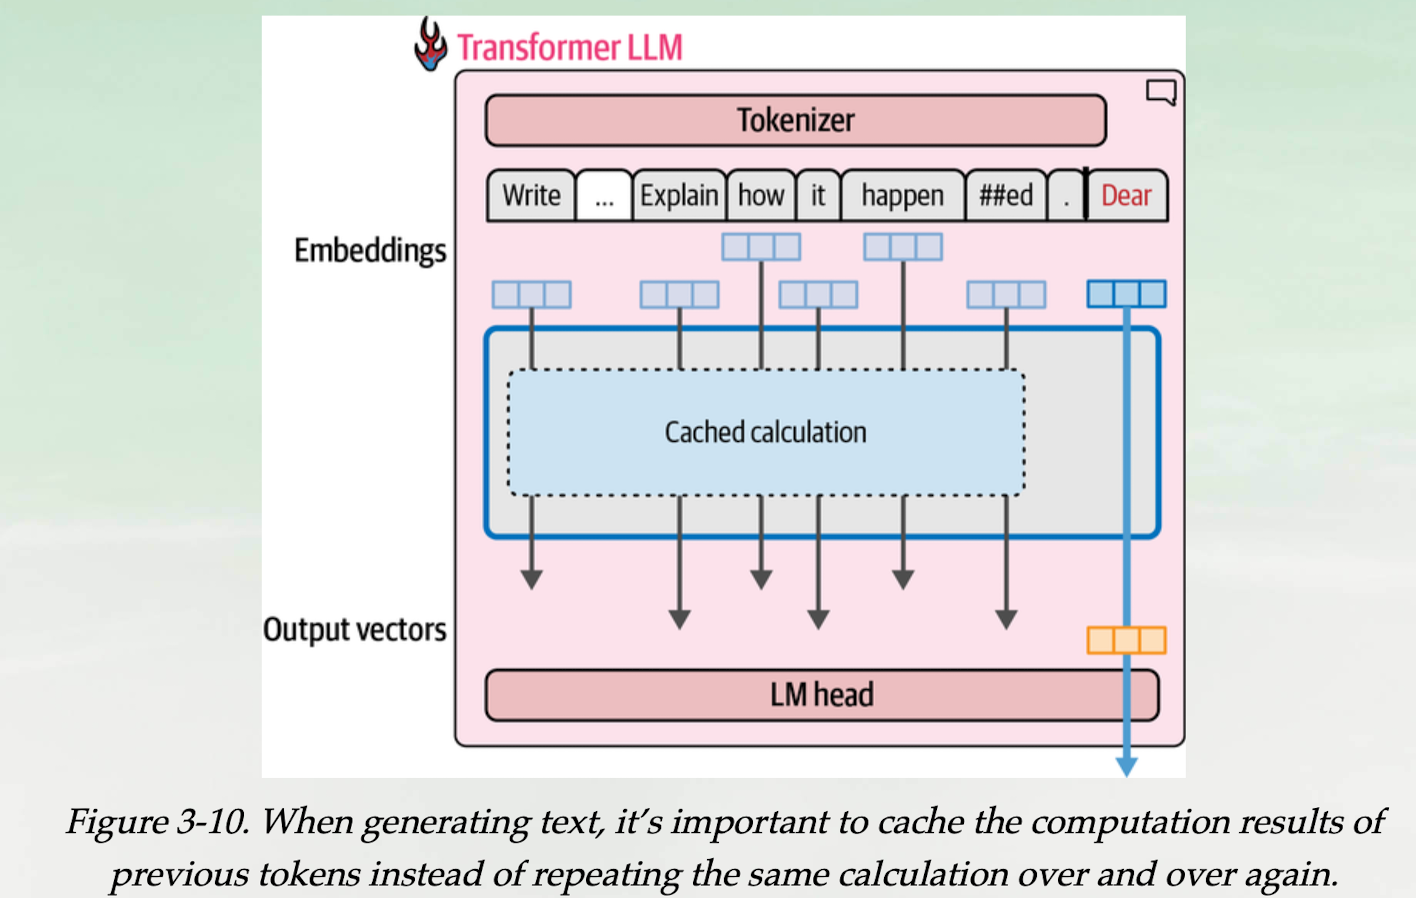

In [13]:
prompt = "Write a very long email apologizing to Sarah for the tragic gardening mishap. Explain how it happened."

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
input_ids = input_ids.to("cuda")

# 下面的代码是开启（默认行为）和关闭cache的模型生成速度对比，可以看到差距非常明显。

In [14]:
%%timeit -n 1
# Generate the text
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=100,
  use_cache=True
)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


6.35 s ± 2.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit -n 1
# Generate the text
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=100,
  use_cache=False
)

32.9 s ± 251 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


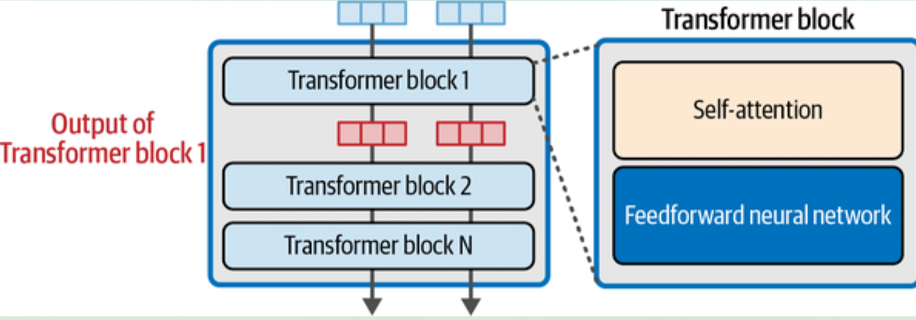

**一个transformer block由self-attention layer和feedforward layer组成。**
自注意层主要关注从其他token和位置中融入相关信息。
前馈层容纳了模型大部分处理能力。

## feed forward layer
这个前馈神经网络层似乎完成了模型的主要记忆和插入能力，memorization and interpolation。

LLM不仅仅是在训练中记住了海量的信息，并且还能能够在data points之间正确地插入数据，从而实现生成：在没见过的input情况下依然产生很好的输出。

### note
对于比较原始的LLM比如gpt3，当输入The Shawshank，它可能会生成Redemption。
但对于现代化的LLM比如gpt4，它会生成很长的一段关于这个电影的描述，这是因为对raw LLM做了改进，提升了满足人类预期诉求的相关能力。

## self-attention layer
